In [1]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("in colab?", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")
    os.chdir('/content/drive/MyDrive/Denoise/cxr-experiment')
    !pwd # print current path
    # Install non-standard colab dependencies.
    !pip install torchinfo
    !pip install torchmetrics
    !pip install torchxrayvision

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime
import pickle
import os
import torchxrayvision as xrv

# after !pip install (in case of colab)
from torchmetrics.image import StructuralSimilarityIndexMeasure
import torchinfo

from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

torch.cuda.empty_cache()

# Select device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()

print("Device: {}".format(device))

# util functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


from utils.cxr_processing import *
from utils.diagnosis import *
from utils.cxr_dataset import *
from utils.cxr_display import *
from utils.patch_dataset import *

in colab? False


c:\Users\Morris\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchxrayvision\utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Device: cuda


In [ ]:
# USE THIS BLOCK COPIES THE NIH DATASET TO LOCAL COLAB INSTANCE AND IMPORTS THE NIH DATASET
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive/')

NIH_DATA_PATH = "/content/data/NIH_data"
DRIVE_PATH = "/content/drive/MyDrive/Datasets"
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile(f"{DRIVE_PATH}/NIH_data.zip", 'r')
if not os.path.exists(NIH_DATA_PATH):
  print("data path does not exist")
  zip_ref.extractall("/content/data") # can take 10-20min, but will make access very fast (30+ imgs/s)
  zip_ref.close()

# Import NIH_Dataset class
#NOTEBOOK_PATH = os.getcwd() # copy the dataset class file to the cwd
#os.system(f"cp {DRIVE_PATH}/nih_dataset.py {NOTEBOOK_PATH}")
from nih_dataset import *


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
from nih_dataset import *
DATA_PATH = NIH_DATA_PATH 
# DATA_PATH = "../data/NIH"

nih_train = NIH_Dataset(DATA_PATH, split="train")
nih_val = NIH_Dataset(DATA_PATH, split="val")
nih_test = NIH_Dataset(DATA_PATH, split="test")

LIMIT_DATA = None # For Using Full Dataset
LIMIT_DATA = [32000, 16000, None] # For Testing

if LIMIT_DATA:
  nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
  nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
  nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test

BATCH_SIZE = 4

train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)

NOISE_STRENGTH = 0.4
MIN_SIGNAL = 0.05

#NOISE_MOD = NoiseModule(NOISE_STRENGTH, MIN_SIGNAL).to(device)
NOISE_MOD = CameraDistort()

plot_cxr_images([nih_train[0][0][0], NOISE_MOD(nih_train[0][0])[0]], ["clean", "noisy"], figsize=(20, 40)) # show example
print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")

NameError: name 'NIH_DATA_PATH' is not defined

In [ ]:
# PATCH TRAINING CONFIGURATION
TRAINING_STEPS = [
    dict(patch_size=256, epochs=10, batch_size=32),
    dict(patch_size=512, epochs=5,  batch_size=8),
    dict(patch_size=1024, epochs=2, batch_size=2),
]

# Create one DataLoader per stage
training_step_dataloaders = [
    DataLoader(
        RandomPatchDataset(nih_train, patch_size=step["patch_size"]),
        batch_size=step["batch_size"],
        pin_memory=True,
        num_workers=4,
        prefetch_factor=2,
        drop_last=True
    )
    for step in TRAINING_STEPS
]

# Extract epochs and total epoch count
num_epochs = sum([step["epochs"] for step in TRAINING_STEPS])


NameError: name 'nih_train' is not defined

In [23]:
# Load diagnosis model for evaluation
diagnosis_model = xrv.models.DenseNet(weights="densenet121-res224-nih")
diagnosis_model.to(device)
diagnosis_model.eval()

diagnosis_val_tester = NihTester(nih_val, device=device)
diagnosis_test_tester = NihTester(nih_test, device=device)

In [24]:
from utils.unet import UNet
model = UNet(s=4, k=64).to(device)
torchinfo.summary(model, (BATCH_SIZE,1,1024,1024))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [4, 1, 1024, 1024]        --
├─ModuleList: 1-1                             --                        --
│    └─EncoderStep: 2-1                       [4, 64, 512, 512]         --
│    │    └─DoubleConv: 3-1                   [4, 64, 1024, 1024]       37,824
│    │    └─MaxPool2d: 3-2                    [4, 64, 512, 512]         --
│    └─EncoderStep: 2-2                       [4, 128, 256, 256]        --
│    │    └─DoubleConv: 3-3                   [4, 128, 512, 512]        221,952
│    │    └─MaxPool2d: 3-4                    [4, 128, 256, 256]        --
│    └─EncoderStep: 2-3                       [4, 256, 128, 128]        --
│    │    └─DoubleConv: 3-5                   [4, 256, 256, 256]        886,272
│    │    └─MaxPool2d: 3-6                    [4, 256, 128, 128]        --
│    └─EncoderStep: 2-4                       [4, 512, 64, 64]          --
│    │

In [ ]:
torch.cuda.empty_cache()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

train_loss_hist, val_loss_hist, val_ssim_hist, val_diag_auc_hist, val_epoch_idxs = [], [], [], [], []
start_time = last_epoch_time = time.time()

# --- auc baselines ---
diagnosis_val_tester.gather_outputs_labels_module(NOISE_MOD)
noisy_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

diagnosis_val_tester.gather_outputs_labels_module(nn.Identity())
clean_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

print(f"auc baselines: noisy={noisy_auc:.4f}, clean={clean_auc:.4f}")

# --- Training Loop with Patch Stages ---
global_epoch = 0
for step_idx, (step, train_dl) in enumerate(zip(TRAINING_STEPS, training_step_dataloaders)):
    print(f"\n--- Training Step {step_idx + 1}/{len(TRAINING_STEPS)}: "
          f"patch_size={step['patch_size']}, epochs={step['epochs']}, batch_size={step['batch_size']} ---")
    
    for local_epoch in range(step["epochs"]):
        model.train()
        train_loss = 0.0
        train_ssim = 0.0

        for i, (clean, _lbls) in enumerate(tqdm(train_dl)):
            clean = clean.to(device)
            noisy = NOISE_MOD(clean).to(device)

            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)
            # train_ssim += ssim(clean, outputs).item() * noisy.size(0)  # optional

        train_loss /= len(train_dl.dataset)
        train_loss_hist.append(train_loss)

        plot_cxr_images(
            [clean[0], noisy[0], outputs[0], outputs[0].clamp(0,1)],
            ["clean", "noisy", "out", "clamp"]
        )

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_ssim = 0.0
        with torch.no_grad():
            for i, (clean, _lbls) in enumerate(tqdm(val_dl)):
                clean = clean.to(device)
                noisy = NOISE_MOD(clean).to(device)

                outputs = model(noisy)
                loss = criterion(outputs, clean)

                val_loss += loss.item() * noisy.size(0)
                val_ssim += ssim(clean, outputs.clamp(0,1)).item() * noisy.size(0)

            val_loss /= len(val_dl.dataset)
            val_ssim /= len(val_dl.dataset)

            val_loss_hist.append(val_loss)
            val_ssim_hist.append(val_ssim)

            plot_cxr_images(
                [clean[0], noisy[0], outputs[0], outputs[0].clamp(0,1)],
                ["clean", "noisy", "out", "clamp"], figsize=(20, 80)
            )

            noise_denoise_module = nn.Sequential(NOISE_MOD, model)
            diagnosis_val_tester.gather_outputs_labels_module(noise_denoise_module)
            avg_auc = diagnosis_val_tester.avg_diagnosis_auc()

            val_diag_auc_hist.append(avg_auc)
            val_epoch_idxs.append(global_epoch)

            print(f"Epoch {global_epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val SSIM: {val_ssim:.4f}, "
                  f"avg AUC: {avg_auc:.4f} (noisy={noisy_auc:.4f}, clean={clean_auc:.4f})"
            )

            torch.save({
                'epoch': global_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
            }, f"models/checkpoints/checkpoint_epoch_{global_epoch}.pth")

        global_epoch += 1

Gathering outputs/labels: 100%|██████████| 1000/1000 [04:59<00:00,  3.33it/s]


auc baselines: noisy=0.4941, clean=0.7516


 60%|█████▉    | 4775/8000 [38:28<25:58,  2.07it/s]

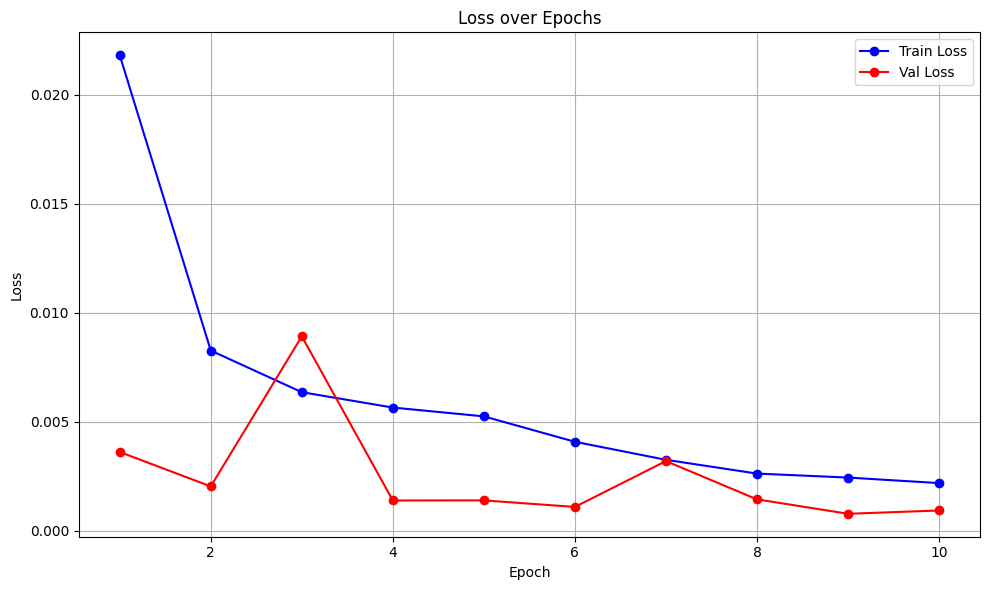

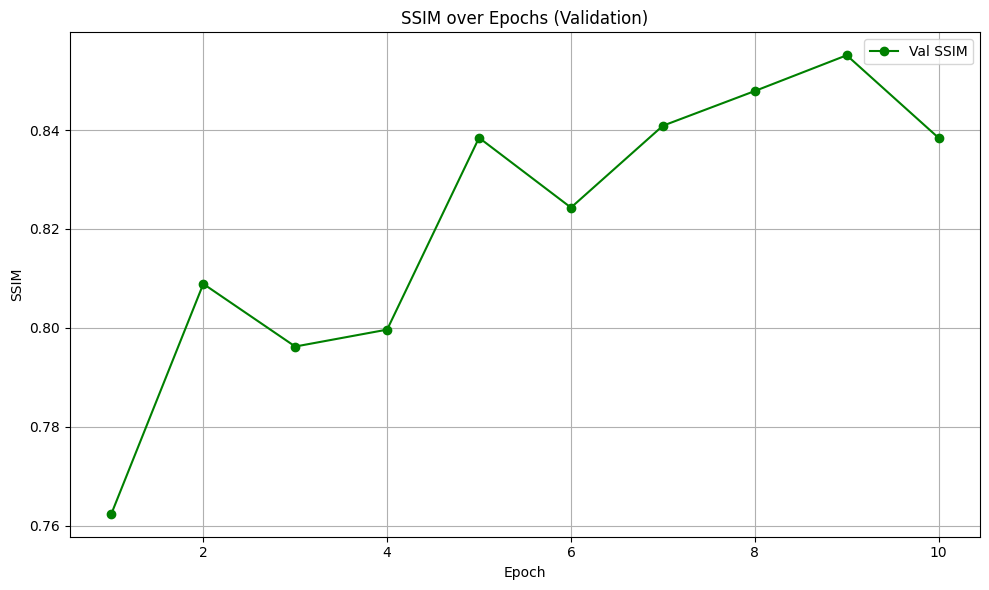

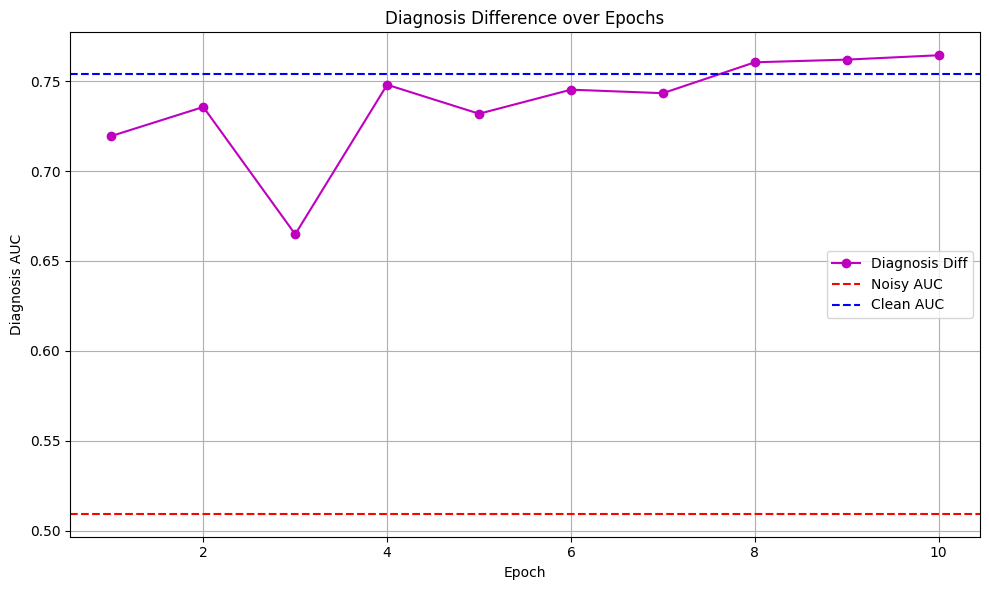

In [ ]:
# --- Plotting ---
epochs = list(range(1, num_epochs + 1))
val_epochs = [i + 1 for i in val_epoch_idxs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_hist, "b-o", label="Train Loss")
plt.plot(val_epochs, val_loss_hist, "r-o", label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_ssim_hist, "g-o", label="Val SSIM")
plt.title("SSIM over Epochs (Validation)")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_diag_auc_hist, "m-o", label="Diagnosis Diff")

plt.axhline(y=noisy_auc, color='r', linestyle='--', label="Noisy AUC")
plt.axhline(y=clean_auc, color='b', linestyle='--', label="Clean AUC")

plt.title("Diagnosis Difference over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Diagnosis AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


In [ ]:
# --- Final Test Evaluation ---
model.eval()
test_loss = 0.0
test_ssim_score = 0.0

with torch.no_grad():
    for (clean, _lbls) in tqdm(test_dl, desc="Final Test Evaluation"):
        clean = clean.to(device)
        noisy = NOISE_MOD(clean).to(device)

        outputs = model(noisy)
        test_loss += criterion(outputs, clean).item() * noisy.size(0)
        test_ssim_score += ssim(outputs, clean).item() * noisy.size(0)

test_loss /= len(test_dl.dataset)
test_ssim_score /= len(test_dl.dataset)

diagnosis_val_tester.gather_outputs_labels_module(NOISE_MOD)
test_noisy_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

diagnosis_val_tester.gather_outputs_labels_module(nn.Identity())
test_clean_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

diagnosis_val_tester.gather_outputs_labels_module(MedianFilter(device))
test_median_filter_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

noise_denoise_module = nn.Sequential(NOISE_MOD, model)
diagnosis_val_tester.gather_outputs_labels_module(noise_denoise_module)
test_avg_auc = diagnosis_val_tester.avg_diagnosis_auc()

print(f"""
--- Final Test Performance ---
Test Loss:         {test_loss:.4f}
Test SSIM:         {test_ssim_score:.4f}
Diagnosis Avg AUC:    {test_avg_auc:.4f} (noisy={test_noisy_auc:.4f}, clean={test_clean_auc:.4f}, median_filter={test_median_filter_auc:.4f})
""")

random_three_letters = "".join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz"), 3))
torch.save(model.state_dict(), f"models/{model.name()}_{random_three_letters}.pth")

import json
from datetime import datetime

model_metadata = {
    "model_name": model.name(),
    "model_name_random_suffix": random_three_letters,
    "model_file_name": f"{model.name()}_{random_three_letters}.pth",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "architecture": "UNet",
    "s": model.s,
    "k": model.k,
    "num_parameters": sum(p.numel() for p in model.parameters()),
    "num_epochs": num_epochs,
    "num_train_images": len(train_dl.dataset),
    "val_loss": val_loss_hist[-1] if val_loss_hist else None,
    "val_ssim": val_ssim_hist[-1] if val_ssim_hist else None,
    "val_diag_diff": val_diag_auc_hist[-1] if val_diag_auc_hist else None,
    "test_loss": test_loss,
    "test_ssim": test_ssim_score,
    "test_diag_avg_auc": test_avg_auc
}

with open(f"models/{model.name()}_{random_three_letters}_meta.json", "w") as f:
    json.dump(model_metadata, f, indent=4)

torch.save({
    "model_state": model.state_dict(),
    "metadata": model_metadata
}, f"models/{model.name()}_{random_three_letters}_bundle.pth")

print(f"!saved model: '{model.name()}_{random_three_letters}'!")

Gathering outputs/labels: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]



--- Final Test Performance ---
Test Loss:         0.0009
Test SSIM:         0.8307
Diagnosis Avg AUC:    0.7712 (noisy=0.5796, clean=0.7824, median_filter=0.7834)

!saved model: 'unet-s4k64_row'!
